In [22]:
import numpy as np  # Para operaciones numéricas y manipulación de arrays
import pandas as pd  # Para manipulación de datos y creación de DataFrames
import matplotlib.pyplot as plt  # Para visualización de gráficos
from astropy.io import fits  # Para leer archivos FITS
from sklearn.model_selection import train_test_split  # Para dividir datos en conjuntos de entrenamiento y validación
import tensorflow as tf  # Para trabajar con TensorFlow
from tensorflow.keras.models import load_model  # Para cargar modelos Keras previamente guardados
import tensorflow_addons as tfa  # Para trabajar con capas adicionales de TensorFlow
from tensorflow.keras.utils import CustomObjectScope  # Para cargar modelos Keras con objetos personalizados


## Catálogo de Marcos

In [23]:
path_datos = "../data/"
path = path_datos + "ZW2.msw_image.fits"
hdul = fits.open(path)

# Leer el archivo de texto con las posiciones de las galaxias
with open("galaxias_sextractor_marcos.txt", "r") as f:
    lines = f.readlines()

# Crear un ndarray de ceros con la misma forma que tus imágenes
label = np.zeros((2048, 2048), dtype=int)

# Función para mantener las coordenadas dentro de los límites de la imagen
def clamp(value, min_value, max_value):
    return max(min(value, max_value), min_value)

# Establecer a 1 las posiciones correspondientes a las galaxias
for line in lines:
    x, y, _ = line.split()
    x, y = int(float(x)), int(float(y))

    # Establecer 1 en un área de 8x8 píxeles alrededor de la posición central de cada galaxia
    for i in range(-4, 4):
        for j in range(-4, 4):
            x_coord = clamp(x + i, 0, 2047)
            y_coord = clamp(y + j, 0, 2047)
            label[y_coord, x_coord] = 1

In [24]:
all_data = hdul[0].data

# Cargar los índices desde el archivo de texto
def load_indices_from_txt(filename="indices.txt"):
    indices = np.loadtxt(filename, dtype=int)
    return indices

indices_from_file = load_indices_from_txt("indices.txt")

# Obtener los índices que no están en el archivo
all_indices = set(range(all_data.shape[0]))
indices_not_in_file = sorted(list(all_indices.difference(indices_from_file)))

# Seleccionar datos utilizando los índices que no están en el archivo
data = all_data[indices_not_in_file]

# Seleccionamos 10 imagenes solo para que pueda compilar
data = data[:10]

# Reformatear y normalizar las imágenes
input_data = np.array(data)
input_data = input_data.reshape((data.shape[0], data.shape[1], data.shape[2], 1)) #600, 2048, 2048, 1
input_data = input_data.astype("float32") / 255.0

# Crear un array de salida repetido x veces (uno para cada imagen de entrada)
output_data = np.repeat(label[np.newaxis, :, :], data.shape[0], axis=0)

In [25]:
with CustomObjectScope({'InstanceNormalization': tfa.layers.InstanceNormalization}):
    model = load_model("cnn1.h5")

2023-04-17 16:15:00.976748: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5368709120 exceeds 10% of free system memory.
2023-04-17 16:15:01.351514: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5368709120 exceeds 10% of free system memory.


1/1 [==============================] - 3s 3s/step


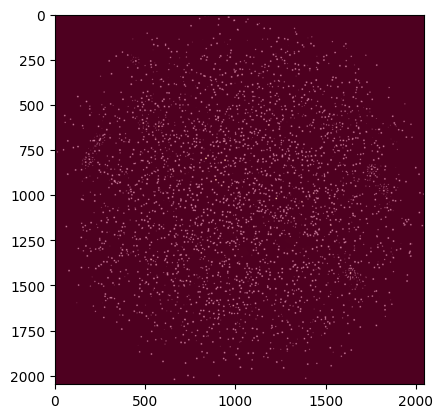

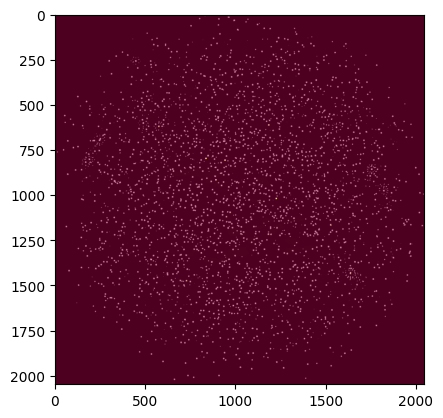

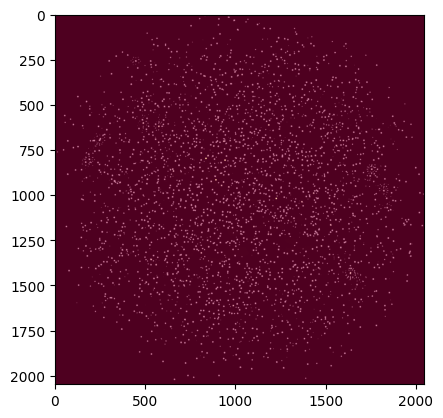

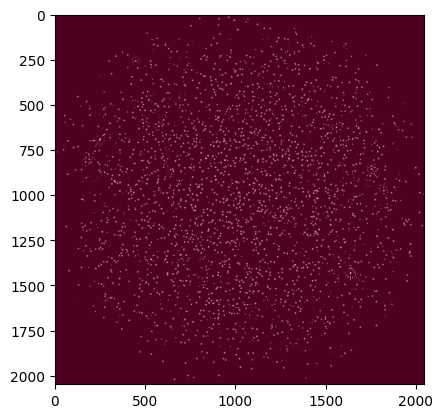

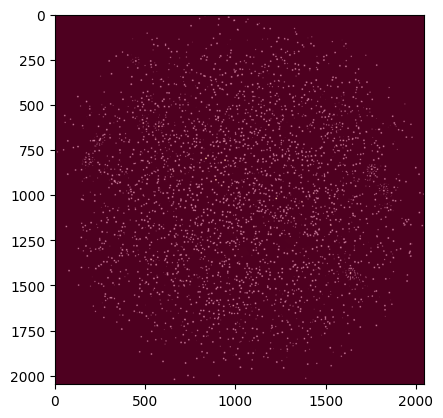

In [26]:
# Predecir con el modelo
predictions = model.predict(input_data)
predictions = np.round(predictions).astype(int)  # Redondear las predicciones a 0 o 1 (aqui se puede cambiar el umbral)

# Graficar los resultados de 5 imágenes
num_images_to_show = 5
for i in range(num_images_to_show):
    plt.figure()
    plt.imshow(predictions[i], cmap="gray")  # Predicción
    plt.imshow(input_data[i], cmap="Spectral", alpha=0.5)  # Imagen
    plt.show()

In [27]:

# Función para obtener las coordenadas de las fuentes
def get_source_coordinates(lines):
    coords = []
    for idx, line in enumerate(lines):
        x, y, _ = line.split()
        x, y = int(float(x)), int(float(y))
        coords.append((idx, x, y))
    return coords

# Obtener las coordenadas de las fuentes y sus números
source_coordinates = get_source_coordinates(lines)

# Función para obtener la probabilidad promedio de una región de 8x8 alrededor de una coordenada
def get_region_probability(prediction, x, y):
    region = prediction[y - 4 : y + 4, x - 4 : x + 4]
    return region.mean()


In [28]:
results = []

# Iterar sobre los primeros 10 elementos de indices_not_in_file
for local_idx, global_idx in enumerate(indices_not_in_file[:10]):
    prediction = predictions[local_idx]
    data = []
    for source_idx, x, y in source_coordinates:
        probability = get_region_probability(prediction, x, y)
        data.append([source_idx, x, y, probability])

    # Crear un DataFrame con los resultados y guardarlo en la lista 'results'
    df = pd.DataFrame(data, columns=["source_number", "x", "y", f"probability_image_{global_idx}"])
    results.append(df)

# Combinar todos los DataFrames en uno solo usando un merge iterativo
final_df_m = results[0]

for i in range(1, len(results)):
    final_df_m = final_df_m.merge(results[i], on=["source_number", "x", "y"], how="outer")


In [29]:
final_df_m

,source_number,x,y,probability_image_0,probability_image_1,probability_image_4,probability_image_5,probability_image_7,probability_image_9,probability_image_10,probability_image_11,probability_image_16,probability_image_18
0,0,830,7,0.875000,0.875000,0.875000,0.859375,0.859375,0.859375,0.843750,0.843750,0.812500,0.812500
1,1,908,27,0.890625,0.875000,0.875000,0.906250,0.921875,0.921875,0.921875,0.906250,0.875000,0.890625
2,2,992,35,0.984375,0.984375,0.984375,0.984375,0.984375,0.984375,0.984375,0.984375,0.984375,0.984375
3,3,1121,58,0.984375,0.984375,0.984375,0.984375,0.984375,0.984375,0.968750,0.968750,0.984375,0.984375
4,4,904,61,0.718750,0.718750,0.703125,0.703125,0.703125,0.703125,0.703125,0.703125,0.703125,0.703125
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1701,1701,1079,1068,0.640625,0.640625,0.640625,0.640625,0.640625,0.640625,0.640625,0.640625,0.656250,0.656250
1702,1702,694,1066,0.921875,0.921875,0.921875,0.921875,0.921875,0.937500,0.937500,0.937500,0.906250,0.921875
1703,1703,1291,1059,0.453125,0.453125,0.437500,0.468750,0.437500,0.453125,0.453125,0.453125,0.453125,0.437500
1704,1704,1356,1037,0.078125,0.078125,0.078125,0.078125,0.093750,0.093750,0.093750,0.093750,0.109375,0.109375


In [30]:
final_df_m.to_csv("resultados_catalogo_marcos.csv", index=False)


In [39]:
final_df_m_transposed = final_df_m.T
final_df_m_transposed = final_df_m_transposed.iloc[3:]
final_df_m_transposed

,0,1,2,3,4,5,6,7,8,9,...,1696,1697,1698,1699,1700,1701,1702,1703,1704,1705
probability_image_0,0.875000,0.890625,0.984375,0.984375,0.718750,0.921875,0.96875,0.875000,0.875000,0.937500,...,0.796875,0.609375,0.984375,0.875,0.843750,0.640625,0.921875,0.453125,0.078125,0.812500
probability_image_1,0.875000,0.875000,0.984375,0.984375,0.718750,0.921875,0.96875,0.875000,0.859375,0.937500,...,0.796875,0.593750,0.984375,0.875,0.843750,0.640625,0.921875,0.453125,0.078125,0.812500
probability_image_4,0.875000,0.875000,0.984375,0.984375,0.703125,0.921875,0.96875,0.906250,0.875000,0.921875,...,0.796875,0.640625,0.984375,0.875,0.843750,0.640625,0.921875,0.437500,0.078125,0.796875
probability_image_5,0.859375,0.906250,0.984375,0.984375,0.703125,0.921875,0.96875,0.906250,0.875000,0.921875,...,0.796875,0.640625,0.984375,0.875,0.859375,0.640625,0.921875,0.468750,0.078125,0.796875
probability_image_7,0.859375,0.921875,0.984375,0.984375,0.703125,0.937500,0.96875,0.890625,0.875000,0.921875,...,0.796875,0.640625,0.984375,0.875,0.859375,0.640625,0.921875,0.437500,0.093750,0.781250
probability_image_9,0.859375,0.921875,0.984375,0.984375,0.703125,0.921875,0.96875,0.875000,0.875000,0.921875,...,0.796875,0.640625,0.984375,0.875,0.843750,0.640625,0.937500,0.453125,0.093750,0.781250
probability_image_10,0.843750,0.921875,0.984375,0.968750,0.703125,0.921875,0.96875,0.875000,0.875000,0.921875,...,0.812500,0.640625,0.984375,0.875,0.843750,0.640625,0.937500,0.453125,0.093750,0.781250
probability_image_11,0.843750,0.906250,0.984375,0.968750,0.703125,0.890625,0.96875,0.875000,0.859375,0.921875,...,0.812500,0.640625,0.984375,0.875,0.843750,0.640625,0.937500,0.453125,0.093750,0.781250
probability_image_16,0.812500,0.875000,0.984375,0.984375,0.703125,0.890625,0.96875,0.828125,0.890625,0.906250,...,0.796875,0.640625,0.984375,0.875,0.843750,0.656250,0.906250,0.453125,0.109375,0.781250
probability_image_18,0.812500,0.890625,0.984375,0.984375,0.703125,0.890625,0.96875,0.812500,0.859375,0.921875,...,0.796875,0.640625,0.984375,0.875,0.843750,0.656250,0.921875,0.437500,0.109375,0.781250


In [41]:
final_df_m_transposed.describe()

,0,1,2,3,4,5,6,7,8,9,...,1696,1697,1698,1699,1700,1701,1702,1703,1704,1705
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.851562,0.898438,0.984375,0.981250,0.706250,0.914062,0.96875,0.871875,0.871875,0.923438,...,0.800000,0.632812,0.984375,0.875,0.846875,0.643750,0.925000,0.450000,0.090625,0.790625
std,0.023582,0.019833,0.000000,0.006588,0.006588,0.016877,0.00000,0.030190,0.009882,0.008869,...,0.006588,0.016877,0.000000,0.000,0.006588,0.006588,0.009882,0.009882,0.012325,0.013176
min,0.812500,0.875000,0.984375,0.968750,0.703125,0.890625,0.96875,0.812500,0.859375,0.906250,...,0.796875,0.593750,0.984375,0.875,0.843750,0.640625,0.906250,0.437500,0.078125,0.781250
25%,0.843750,0.878906,0.984375,0.984375,0.703125,0.898438,0.96875,0.875000,0.863281,0.921875,...,0.796875,0.640625,0.984375,0.875,0.843750,0.640625,0.921875,0.441406,0.078125,0.781250
50%,0.859375,0.898438,0.984375,0.984375,0.703125,0.921875,0.96875,0.875000,0.875000,0.921875,...,0.796875,0.640625,0.984375,0.875,0.843750,0.640625,0.921875,0.453125,0.093750,0.781250
75%,0.871094,0.917969,0.984375,0.984375,0.703125,0.921875,0.96875,0.886719,0.875000,0.921875,...,0.796875,0.640625,0.984375,0.875,0.843750,0.640625,0.933594,0.453125,0.093750,0.796875
max,0.875000,0.921875,0.984375,0.984375,0.718750,0.937500,0.96875,0.906250,0.890625,0.937500,...,0.812500,0.640625,0.984375,0.875,0.859375,0.656250,0.937500,0.468750,0.109375,0.812500


## Catálogo de Andrés

In [31]:
# Leer el archivo de texto con las posiciones de las galaxias
with open("galaxias_sextractor.txt", "r") as f:
    lines = f.readlines()

# Crear un ndarray de ceros con la misma forma que tus imágenes
label = np.zeros((2048, 2048), dtype=int)

# Función para mantener las coordenadas dentro de los límites de la imagen
def clamp(value, min_value, max_value):
    return max(min(value, max_value), min_value)

# Establecer a 1 las posiciones correspondientes a las galaxias
for line in lines:
    x, y, _ = line.split()
    x, y = int(float(x)), int(float(y))

    # Establecer 1 en un área de 8x8 píxeles alrededor de la posición central de cada galaxia
    for i in range(-4, 4):
        for j in range(-4, 4):
            x_coord = clamp(x + i, 0, 2047)
            y_coord = clamp(y + j, 0, 2047)
            label[y_coord, x_coord] = 1


In [32]:
num_evaluated_images = 10

galaxy_results = []

for local_idx, global_idx in zip(range(num_evaluated_images), indices_not_in_file[:num_evaluated_images]):
    prediction = predictions[local_idx]
    data = []
    for source_idx, x, y in galaxy_coordinates:
        probability = get_region_probability(prediction, x, y)
        data.append([source_idx, x, y, probability])

    # Crear un DataFrame con los resultados y guardarlo en la lista 'galaxy_results'
    df = pd.DataFrame(data, columns=["source_number", "x", "y", f"probability_image_{global_idx}"])
    galaxy_results.append(df)

# Combinar todos los DataFrames en uno solo usando un merge iterativo
final_df_a = galaxy_results[0]

for i in range(1, len(galaxy_results)):
    final_df_a = final_df_a.merge(galaxy_results[i], on=["source_number", "x", "y"], how="outer")

/tmp/ipykernel_16211/1237829359.py:16: RuntimeWarning: Mean of empty slice.
  return region.mean()
/home/21953404Victor/SDC3/tutorial-env/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_16211/1237829359.py:16: RuntimeWarning: Mean of empty slice.
  return region.mean()
/home/21953404Victor/SDC3/tutorial-env/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_16211/1237829359.py:16: RuntimeWarning: Mean of empty slice.
  return region.mean()
/home/21953404Victor/SDC3/tutorial-env/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_16211/1237829359.py:16: RuntimeWarning: Mean of empty slice.
  return region.mean()
/home/21953404Victor/SDC3

In [33]:
final_df_a

,source_number,x,y,probability_image_0,probability_image_1,probability_image_4,probability_image_5,probability_image_7,probability_image_9,probability_image_10,probability_image_11,probability_image_16,probability_image_18
0,0,842,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,738,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,848,10,0.046875,0.015625,0.015625,0.015625,0.015625,0.000000,0.00000,0.00000,0.00000,0.000000
3,3,830,7,0.875000,0.875000,0.875000,0.859375,0.859375,0.859375,0.84375,0.84375,0.81250,0.812500
4,4,961,17,0.859375,0.859375,0.828125,0.828125,0.828125,0.843750,0.84375,0.84375,0.84375,0.828125
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4901,4901,704,1919,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000
4902,4902,768,2011,0.843750,0.812500,0.781250,0.718750,0.750000,0.718750,0.71875,0.71875,0.68750,0.671875
4903,4903,1155,1782,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000
4904,4904,709,1720,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000


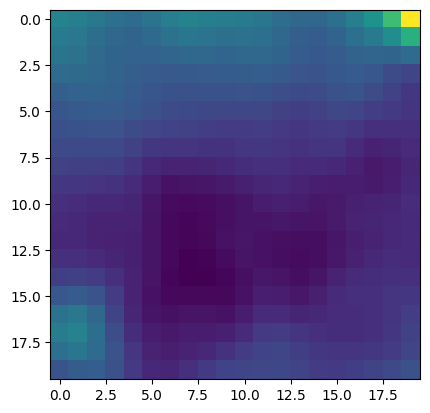

In [50]:
x=1079
y=1068
xmin,xmax=x-10,x+10
ymin,ymax=y-10,y+10
	

plt.imshow(hdul[0].data[0][xmin:xmax,ymin:ymax])

In [34]:
final_df_a.to_csv("resultados_catalogo_andres.csv", index=False)

In [40]:
final_df_a_transposed = final_df_a.T
final_df_a_transposed = final_df_a_transposed.iloc[3:]
final_df_a_transposed

,0,1,2,3,4,5,6,7,8,9,...,4896,4897,4898,4899,4900,4901,4902,4903,4904,4905
probability_image_0,NaN,NaN,0.046875,0.875000,0.859375,0.703125,0.0,0.890625,0.546875,0.656250,...,0.140625,0.343750,0.125000,0.0,0.0,0.0,0.843750,0.0,0.0,0.0
probability_image_1,NaN,NaN,0.015625,0.875000,0.859375,0.703125,0.0,0.875000,0.546875,0.656250,...,0.140625,0.296875,0.109375,0.0,0.0,0.0,0.812500,0.0,0.0,0.0
probability_image_4,NaN,NaN,0.015625,0.875000,0.828125,0.656250,0.0,0.875000,0.500000,0.609375,...,0.140625,0.250000,0.171875,0.0,0.0,0.0,0.781250,0.0,0.0,0.0
probability_image_5,NaN,NaN,0.015625,0.859375,0.828125,0.671875,0.0,0.906250,0.515625,0.609375,...,0.109375,0.281250,0.218750,0.0,0.0,0.0,0.718750,0.0,0.0,0.0
probability_image_7,NaN,NaN,0.015625,0.859375,0.828125,0.640625,0.0,0.921875,0.453125,0.625000,...,0.171875,0.234375,0.218750,0.0,0.0,0.0,0.750000,0.0,0.0,0.0
probability_image_9,NaN,NaN,0.000000,0.859375,0.843750,0.640625,0.0,0.921875,0.468750,0.640625,...,0.109375,0.250000,0.156250,0.0,0.0,0.0,0.718750,0.0,0.0,0.0
probability_image_10,NaN,NaN,0.000000,0.843750,0.843750,0.625000,0.0,0.921875,0.468750,0.640625,...,0.015625,0.328125,0.125000,0.0,0.0,0.0,0.718750,0.0,0.0,0.0
probability_image_11,NaN,NaN,0.000000,0.843750,0.843750,0.609375,0.0,0.906250,0.468750,0.640625,...,0.000000,0.312500,0.046875,0.0,0.0,0.0,0.718750,0.0,0.0,0.0
probability_image_16,NaN,NaN,0.000000,0.812500,0.843750,0.546875,0.0,0.875000,0.421875,0.546875,...,0.062500,0.390625,0.125000,0.0,0.0,0.0,0.687500,0.0,0.0,0.0
probability_image_18,NaN,NaN,0.000000,0.812500,0.828125,0.500000,0.0,0.890625,0.406250,0.500000,...,0.109375,0.296875,0.203125,0.0,0.0,0.0,0.671875,0.0,0.0,0.0
